# Andvaranaut tutorial

## Forward Module (Input distributions specified)

### Latin Hypercube Sampling
Import items form forward module as well as utils module

In [39]:
from andvaranaut.forward import *
from andvaranaut.utils import *

In [40]:
# Magic features for development purposes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


User supplies target function, which takes a 1D numpy array of nx inputs and returns a 1D numpy array of ny outputs. They must also supply a list of univariate distributions from scipy stats for each of the nx inputs.

In [41]:
# Example target function (2 inputs, 2 outputs)
# A more complex target function will produce an input file, 
# execute external code, and perform post-processing on output
def test_fun(x):
  x1,x2 = x
  return np.array([x1+x2,x1**2*x2**2])

# Input variable probability distributions
import scipy.stats as st
sample_space = [st.uniform(loc=0,scale=2),\
                st.norm(loc=1,scale=0.5)]

In [42]:
# Latin hypercube class instance, with correct arguments
l = lhc(nx=2,ny=2,dists=sample_space,target=test_fun)

Sampling makes use of the latin_random function from py-design

In [43]:
# Sample input distributions by LHC and evaluate target function
l.sample(nsamps=4)
print(l.x)
print(l.y)

Run is 100.0% complete.
Time taken: 0.00 s
[[1.26446596 0.09256075]
 [0.37931311 0.87475854]
 [0.61551163 1.19881321]
 [1.90403222 1.97964938]]
[[1.35702671e+00 1.36983432e-02]
 [1.25407165e+00 1.10096140e-01]
 [1.81432485e+00 5.44472028e-01]
 [3.88368160e+00 1.42077447e+01]]


Parallel execution makes use of the ray package. This also works with SLURM submission if a SLURM script calls a python script with these commands in. (Tutorial will be added at a later date)

In [44]:
# Can also execute target function evaluation in parallel
l.sample(nsamps=4,parallel=True,nproc=4)
print(l.x)
print(l.y)

2021-05-02 17:32:40,684	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


Run is 100.0% complete.
Time taken: 6.42 s
[[1.26446596 0.09256075]
 [0.37931311 0.87475854]
 [0.61551163 1.19881321]
 [1.90403222 1.97964938]
 [1.89685383 0.22163449]
 [1.42233119 1.00876226]
 [0.12023095 0.995389  ]
 [0.72152196 1.69301085]]
[[1.35702671e+00 1.36983432e-02]
 [1.25407165e+00 1.10096140e-01]
 [1.81432485e+00 5.44472028e-01]
 [3.88368160e+00 1.42077447e+01]
 [2.11848832e+00 1.76743078e-01]
 [2.43109345e+00 2.05863389e+00]
 [1.11561994e+00 1.43224794e-02]
 [2.41453280e+00 1.49217096e+00]]


Plotting output distributions makes use of the kdeplot function from seaborn

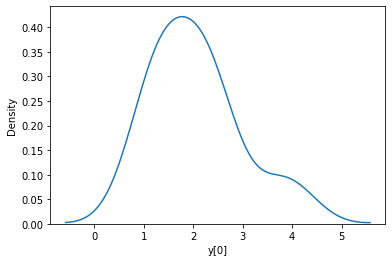

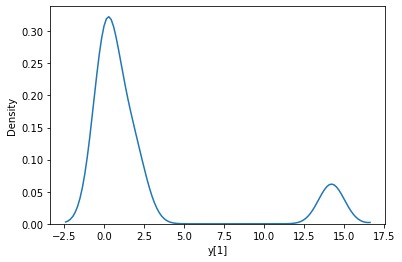

In [45]:
# Plot output distributions based on kernel density estimation
l.y_dist()

In [46]:
# Optionally delete n samples
# Default is deletion by closest sample to a coarse LHC of number of samples for deletion
l.del_samples(ndels=2,method='coarse_lhc')
print(l.x)
print(l.y,'\n')
# Can also delete by random indexing
l.del_samples(ndels=2,method='random')
print(l.x)
print(l.y,'\n')
# or by specific data indexes
l.del_samples(method='specific',idx=[0,1])
print(l.x)
print(l.y,'\n')

[[1.26446596 0.09256075]
 [0.37931311 0.87475854]
 [1.90403222 1.97964938]
 [1.89685383 0.22163449]
 [0.12023095 0.995389  ]
 [0.72152196 1.69301085]]
[[1.35702671e+00 1.36983432e-02]
 [1.25407165e+00 1.10096140e-01]
 [3.88368160e+00 1.42077447e+01]
 [2.11848832e+00 1.76743078e-01]
 [1.11561994e+00 1.43224794e-02]
 [2.41453280e+00 1.49217096e+00]] 

[[1.90403222 1.97964938]
 [1.89685383 0.22163449]
 [0.72152196 1.69301085]
 [1.26446596 0.09256075]]
[[3.88368160e+00 1.42077447e+01]
 [2.11848832e+00 1.76743078e-01]
 [2.41453280e+00 1.49217096e+00]
 [1.35702671e+00 1.36983432e-02]] 

[[0.72152196 1.69301085]
 [1.26446596 0.09256075]]
[[2.4145328  1.49217096]
 [1.35702671 0.01369834]] 



If datasets exist then it is possible to set the class attributes directly with these. They must be in the form of 2d numpy float arrays. An additional consideration is the provided x data must be compatible with the existing distributions.

In [83]:
x = np.random.rand(5,2)
y = np.random.rand(5,2)
l.set_data(x=x,y=y)
print(l.x)
print(l.y)

[[0.74427029 0.21081554]
 [0.66888992 0.66446038]
 [0.37393019 0.65284838]
 [0.96405112 0.53230062]
 [0.23570368 0.04595651]]
[[0.22305854 0.32565401]
 [0.9480615  0.44434616]
 [0.87129371 0.46920286]
 [0.59866937 0.65439872]
 [0.60087841 0.87815703]]


### Gaussian process surrogate

In addition to the arguments provided to the lhc class, there are additional arguments for a list of classes which handle conversion and reversion of the x and y datasets, respectively. These are necessary for optimising surrogate performance, and usually consist of transforming bounded ranges on inputs and outputs to unbounded. Normalisations to get numbers O(1) are also useful and can be implemented either here or within the target function.

These conversion/reversion arguments are optional, and can be left blank if desired. Standard methods are provided in andvaranaut.utils, with the logarithm and uniform classes shown below for clarity on the format. A user can define their own class in this format, as long as any additional arguments like the distribution object in uniform are packaged into partial functions within the class.

In [21]:
# Convert positive values to unbounded with logarithm
def log_con(y):
  return np.log10(y)
# Revert logarithm with power
def log_rev(y):
  return np.power(10,y)
class logarithm:
  def __init__(self):
    self.con = log_con # Conversion function
    self.rev = log_rev # Reversion function

from functools import partial
# Convert uniform dist samples into standard uniform 
def std_uniform(x,dist):
  intv = dist.interval(1.0)
  x = (x-intv[0])/(intv[1]-intv[0])
  return x
# Revert to original uniform distributions
def uniform_rev(x,dist):
  intv = dist.interval(1.0)
  x = x*(intv[1]-intv[0])+intv[0]
  return x
class uniform:
  def __init__(self,dist):
    self.con = partial(std_uniform,dist=dist)
    self.rev = partial(uniform_rev,dist=dist)

In [22]:
# Define lists of conversion/reversion classes for each x and y variable
xconrevs = [logit_logistic(sample_space[0]),normal(sample_space[1])]
yconrevs = [None,nonneg()]
# Instance of gp
g = gp(nx=2,ny=2,dists=sample_space,target=test_fun,xconrevs=xconrevs,yconrevs=yconrevs)

In [23]:
g.sample(5)
print(g.x)
print(g.y)
print(g.xc)
print(g.yc)

Run is 100.0% complete.
Time taken: 0.00 s
[[1.99555315 0.56275989]
 [1.26177996 0.78483788]
 [0.73584554 1.414867  ]
 [0.1559699  2.11892443]
 [0.98611185 1.09076229]]
[[2.55831304 1.26116777]
 [2.04661784 0.98067966]
 [2.15071254 1.08393829]
 [2.27489433 0.1092226 ]
 [2.07687414 1.15694466]]
[[ 6.10648041 -0.87448023]
 [ 0.53603674 -0.43032424]
 [-0.54113854  0.82973401]
 [-2.47004569  2.23784886]
 [-0.02777809  0.18152459]]
[[ 2.55831304  0.2320381 ]
 [ 2.04661784 -0.01950942]
 [ 2.15071254  0.08060097]
 [ 2.27489433 -2.21436725]
 [ 2.07687414  0.14578262]]


## Utils module

### Save and load objects

In [27]:
# Save lhc class including datasets
save_object(obj=l,fname='lhc_tut.pickle')

In [30]:
# Load lhc class
l = load_object(fname='lhc_tut.pickle')
print(l.x)
print(l.y)

[[0.38587561 0.77207081]
 [0.91139096 1.52028782]]
[[1.15794642 0.08875829]
 [2.43167878 1.91982244]]


### Standard conversion/reversion classes

Some examples were shown previously in the tutorial but the full list will be given here for completeness:

normal - requires dist argument upon initialisation and converts samples from any normal distribution to a standard normal sample. 
  
uniform - as above but any uniform distribution to standard uniform.  
  
logit-logistic - requires dist argument and converts any uniform distribution sample to an unbounded range via logit  
  
probit - as above but converts to standard normal sample via distribution cdf's  
  
nonneg - converts any non-negative values to unbounded values by the transformation y' = y/(1+y) which has a range [0,1] and then taking the logit.  
  
logarithm - takes a log with base ten to transform any positive values to unbounded